# OBJECT DETECTION (CLASSIFICATION + LOCALIZATION) ON CUSTOM DATA

This is the part 2 of the notebook https://www.kaggle.com/shweta2407/objectdetection-on-custom-dataset-resnet34. I have explained every part of the code in the above mentioned notebook in detail.

The above notebook is implemented in PyTorch using ResNet34 model, whereas this notebook is implemented in Keras using Xception model.

In [17]:
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical, plot_model
from keras.models import Model
from keras.layers import Dense, Input, BatchNormalization, Dropout
from keras.layers import Flatten
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import cv2
import os
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from keras.layers import GlobalAveragePooling2D, Dense, Input
from keras.applications.xception import Xception 

In [3]:
# READ IMAGES IN COLORED FORMAT
def read_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

# CREATE IMAGE LIST
def create_image_list(image_path):
    image_list = []
    # ITERATE THROUGH IMAGES FOLDER
    for image in os.listdir(image_path):
        # APPEND THE NAME OF IMAGES TO THE LIST
        image_list.append(image)
    return image_list

# CREATE MASK FOR BOUNDING BOX
def create_mask(bb, image):
    # EXTRACT THE IMAGE SHAPE
    rows,cols,*_ = image.shape
    # CREATE A MATRIX OF ZERO OF THE IMAGE SHAPE
    mask = np.zeros((rows, cols))
    # FILL THE MATRIX CONTAINING THE BOUNDING BOX WITH VALUE 1
    mask[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return mask

# CONVERT RESIZED MASK TO BOUNDING BOX
def convert_to_bb(mask):
    # EXTRACT THE SHAPE OF THE MASK OF BOUNDING BOX CREATED
    cols, rows = np.nonzero(mask)
    # RETURN ZERO COORDINATES IF NO MASK
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    # EXTRACT THE BOUNDING BOX COORDINATES
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

# RESIZE THE IMAGES AND SAVE IT IN ANOTHER FOLDER
def image_resize(image_path, new_path, bb, size):
    # READ THE IMAGE FILE
    image = read_image(image_path)
    # RESIZE THE IMAGE
    image_resized = cv2.resize(image, (int(1.49*size), size))
    # CREATE MASK FROM THE BOUNDING BOX
    mask = create_mask(bb, image)
    # RESIZE THE MASK 
    mask_resized = cv2.resize(mask, (int(1.49*size), size))
    # WRITE THE NEW IMAGE INTO ANOTHER FOLDER
    cv2.imwrite(new_path, cv2.cvtColor(image_resized, cv2.COLOR_RGB2BGR))
    return new_path, convert_to_bb(mask_resized)

# PLOT THE BOUNDING BOX AROUND THE IMAGE
def plot_bb(path, bb):
    image = read_image(path)
    # CONVERT BOUNDING BOXES (BB) INTO FLOAT
    bb = np.array(bb, dtype=np.float32)
    # CREATE A RECTANGLE FROM THE BB
    rect_box = plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color='red',
                         fill=False, lw=3)
    # RENDER THE IMAGE
    plt.imshow(image)
    # APPLY THE BB TO THE CURRENT AXIS RENDERING IMAGE
    plt.gca().add_patch(rect_box)

In [4]:
# EXTRACT BOUNDING BOX FROM THE ANNOTATION FILE
def extract_bb(anno_path):
    # PARSE THE XML FILE TO EXTRACT BB COORDINATES AND CLASS_NAME
    root = ET.parse(anno_path).getroot()
    class_name = root.find("./object/name").text
    xmin = int(root.find("./object/bndbox/xmin").text)
    ymin = int(root.find("./object/bndbox/ymin").text)
    xmax = int(root.find("./object/bndbox/xmax").text)
    ymax = int(root.find("./object/bndbox/ymax").text)
    # RETURN BOUNDING BOX COORDINATES
    bb = [ymin, xmin, ymax, xmax]
    return bb, class_name

# GENERATE DATAFRAME
def generate_dataframe(image_list, anno_path, image_path, new_path, size):
    dataset = []
    for image in image_list:
        path = image_path + image
        a_path = anno_path + image.split('.')[0] + '.xml'
        # EXTRACT BB AND CLASS_NAME FROM ANNOTATION FILE
        bb, class_name = extract_bb(a_path)
        # FILENAME OF THE NEW RESIZED IMAGE
        n_path = new_path + image 
        # RESIZE THE IMAGE AND CORRESPONDING BOUNDING BOX 
        img_path, resized_bb = image_resize(path, n_path, bb, size)
        # APPEND EVERYTHING TO A DICTIONARY 
        data = dict()
        data['filename'] = img_path
        data['bb'] = resized_bb
        data['class_name'] = class_name
        # APPEND THE DICTIONARY TO THE LIST
        dataset.append(data)
    # APPEND THE LIST TO THE DATAFRAME 
    return pd.DataFrame(dataset) 

In [5]:
# prepare dataset
def generate_data_array(dataframe):
    
    train_img = []
    classes = []
    bounding_boxes = []
    
    for index, row in dataframe.iterrows():
        path = row['filename']
        x = read_image(path)
        
        # append image
        train_img.append(x)
        # append class labels
        classes.append(row['class_name'])
        # append bb
        bounding_boxes.append(row['bb'])
        
    return train_img, classes, bounding_boxes

In [6]:
!mkdir resized_image

In [7]:
image_path = '../input/currency-datasets/images/'
anno_path =  '../input/currency-datasets/annotations/'
new_path = './resized_image/'

# CREATE IMAGE LIST
image_list = create_image_list(image_path)
# SHUFFLE THE LIST
np.random.shuffle(image_list)

image_list[:5]

['10_6.jpeg',
 '10_22.jpeg',
 '10_3 (copy).jpeg',
 '100_15.jpeg',
 '10_20 (copy).jpeg']

In [8]:
data = generate_dataframe(image_list, anno_path, image_path, new_path, 300)
len(data)

441

In [22]:
data.head()

,filename,bb,class_name
0,./resized_image/10_6.jpeg,"[17.0, 141.0, 71.0, 299.0]",ten
1,./resized_image/10_22.jpeg,"[37.0, 42.0, 121.0, 382.0]",ten
2,./resized_image/10_3 (copy).jpeg,"[30.0, 84.0, 106.0, 328.0]",ten
3,./resized_image/100_15.jpeg,"[80.0, 25.0, 213.0, 408.0]",hundred
4,./resized_image/10_20 (copy).jpeg,"[30.0, 27.0, 124.0, 385.0]",ten


In [9]:
train_img, classes, bounding_boxes = generate_data_array(data)
# ENCODE THE LABEL
le = LabelEncoder()
Y_class = le.fit_transform(classes)

In [10]:
# 0:'50Rs', 1:'500Rs', 2:'100Rs', 3:'10Rs', 4:'20Rs', 5:'200Rs', 6:'2000Rs'
le.inverse_transform([0,1,2,3,4,5,6])

array(['fifty', 'fiveHundred', 'hundred', 'ten', 'twenty', 'twoHundred',
       'twoThousand'], dtype='<U11')

In [11]:
X = np.array(train_img)
Y_class = to_categorical(Y_class)
Y_bb = np.array(bounding_boxes)

# CHECK THE DIMENSIONS
print("shape of X ", X.shape)
print("shape of Y_class ", Y_class.shape)
print("shape of Y_bb ", Y_bb.shape)

shape of X  (441, 300, 447, 3)
shape of Y_class  (441, 7)
shape of Y_bb  (441, 4)


In [12]:
# model = VGG16(include_top=False, input_shape=(224, 333, 3))
# x = Flatten()(model.layers[-1].output)
 
image_input = Input(shape=(300, 447, 3))
base_model = Xception(include_top=False, input_tensor=image_input, weights='imagenet')
x = base_model.layers[-1].output
x = GlobalAveragePooling2D()(x)
# x = BatchNormalization()(x)
# x = Dropout(0.25)(x)

output_1 = Dense(4, activation='relu')(x)
output_2 = Dense(7, activation='softmax')(x)

model = Model(inputs = image_input, outputs =[output_1, output_2])
model.compile(loss=['mae', 'categorical_crossentropy'], optimizer='adam', metrics =['accuracy'])

83689472/83683744 [==============================] - 5s 0us/step


In [13]:
# dense_loss = loss of bb
# dense_1_loss = loss of class
history = model.fit(X, [Y_bb, Y_class], epochs=200, batch_size=8, validation_split=0.2)

Epoch 1/200
44/44 [==============================] - 14s 322ms/step - loss: 162.5403 - dense_loss: 161.6033 - dense_1_loss: 0.9370 - dense_accuracy: 0.3182 - dense_1_accuracy: 0.7358 - val_loss: 263.3961 - val_dense_loss: 211.3093 - val_dense_1_loss: 52.0868 - val_dense_accuracy: 0.1910 - val_dense_1_accuracy: 0.1348
Epoch 2/200
44/44 [==============================] - 13s 298ms/step - loss: 138.6647 - dense_loss: 137.9113 - dense_1_loss: 0.7534 - dense_accuracy: 0.9489 - dense_1_accuracy: 0.8125 - val_loss: 148.0892 - val_dense_loss: 125.7191 - val_dense_1_loss: 22.3701 - val_dense_accuracy: 0.9326 - val_dense_1_accuracy: 0.1011
Epoch 3/200
44/44 [==============================] - 13s 297ms/step - loss: 115.1925 - dense_loss: 114.4707 - dense_1_loss: 0.7218 - dense_accuracy: 0.9517 - dense_1_accuracy: 0.8011 - val_loss: 161.5063 - val_dense_loss: 159.6826 - val_dense_1_loss: 1.8237 - val_dense_accuracy: 0.5281 - val_dense_1_accuracy: 0.3034
Epoch 4/200
44/44 [=========================

Epoch 27/200
44/44 [==============================] - 13s 298ms/step - loss: 15.2660 - dense_loss: 15.0590 - dense_1_loss: 0.2070 - dense_accuracy: 0.9801 - dense_1_accuracy: 0.9318 - val_loss: 15.8151 - val_dense_loss: 15.5128 - val_dense_1_loss: 0.3022 - val_dense_accuracy: 0.9888 - val_dense_1_accuracy: 0.9326
Epoch 28/200
44/44 [==============================] - 13s 298ms/step - loss: 15.3921 - dense_loss: 15.2607 - dense_1_loss: 0.1315 - dense_accuracy: 0.9773 - dense_1_accuracy: 0.9659 - val_loss: 15.8788 - val_dense_loss: 15.4258 - val_dense_1_loss: 0.4530 - val_dense_accuracy: 0.9888 - val_dense_1_accuracy: 0.9101
Epoch 29/200
44/44 [==============================] - 13s 300ms/step - loss: 14.3179 - dense_loss: 14.1599 - dense_1_loss: 0.1580 - dense_accuracy: 0.9801 - dense_1_accuracy: 0.9602 - val_loss: 17.0015 - val_dense_loss: 16.5597 - val_dense_1_loss: 0.4417 - val_dense_accuracy: 0.9775 - val_dense_1_accuracy: 0.8876
Epoch 30/200
44/44 [==============================] - 1

44/44 [==============================] - 13s 298ms/step - loss: 9.3509 - dense_loss: 9.2486 - dense_1_loss: 0.1022 - dense_accuracy: 0.9972 - dense_1_accuracy: 0.9744 - val_loss: 15.7350 - val_dense_loss: 15.4124 - val_dense_1_loss: 0.3226 - val_dense_accuracy: 0.9551 - val_dense_1_accuracy: 0.9551
Epoch 54/200
44/44 [==============================] - 13s 298ms/step - loss: 10.3874 - dense_loss: 10.2594 - dense_1_loss: 0.1280 - dense_accuracy: 0.9972 - dense_1_accuracy: 0.9631 - val_loss: 13.2302 - val_dense_loss: 13.0758 - val_dense_1_loss: 0.1544 - val_dense_accuracy: 0.9775 - val_dense_1_accuracy: 0.9663
Epoch 55/200
44/44 [==============================] - 13s 299ms/step - loss: 9.0973 - dense_loss: 8.9733 - dense_1_loss: 0.1240 - dense_accuracy: 0.9972 - dense_1_accuracy: 0.9773 - val_loss: 13.1929 - val_dense_loss: 12.9873 - val_dense_1_loss: 0.2056 - val_dense_accuracy: 1.0000 - val_dense_1_accuracy: 0.9551
Epoch 56/200
44/44 [==============================] - 13s 299ms/step - l

44/44 [==============================] - 13s 301ms/step - loss: 7.8160 - dense_loss: 7.7476 - dense_1_loss: 0.0684 - dense_accuracy: 1.0000 - dense_1_accuracy: 0.9773 - val_loss: 13.0262 - val_dense_loss: 12.7037 - val_dense_1_loss: 0.3225 - val_dense_accuracy: 0.9775 - val_dense_1_accuracy: 0.9326
Epoch 80/200
44/44 [==============================] - 13s 298ms/step - loss: 7.2997 - dense_loss: 7.2545 - dense_1_loss: 0.0452 - dense_accuracy: 0.9943 - dense_1_accuracy: 0.9886 - val_loss: 12.6835 - val_dense_loss: 12.3645 - val_dense_1_loss: 0.3190 - val_dense_accuracy: 0.9663 - val_dense_1_accuracy: 0.9438
Epoch 81/200
44/44 [==============================] - 13s 298ms/step - loss: 7.9645 - dense_loss: 7.8933 - dense_1_loss: 0.0713 - dense_accuracy: 1.0000 - dense_1_accuracy: 0.9830 - val_loss: 12.7532 - val_dense_loss: 12.4385 - val_dense_1_loss: 0.3147 - val_dense_accuracy: 0.9663 - val_dense_1_accuracy: 0.9438
Epoch 82/200
44/44 [==============================] - 13s 297ms/step - los

44/44 [==============================] - 13s 297ms/step - loss: 6.5524 - dense_loss: 6.4379 - dense_1_loss: 0.1144 - dense_accuracy: 0.9972 - dense_1_accuracy: 0.9688 - val_loss: 11.3583 - val_dense_loss: 11.0224 - val_dense_1_loss: 0.3359 - val_dense_accuracy: 0.9775 - val_dense_1_accuracy: 0.9438
Epoch 106/200
44/44 [==============================] - 13s 298ms/step - loss: 6.6154 - dense_loss: 6.5168 - dense_1_loss: 0.0986 - dense_accuracy: 0.9943 - dense_1_accuracy: 0.9716 - val_loss: 11.4992 - val_dense_loss: 11.1289 - val_dense_1_loss: 0.3703 - val_dense_accuracy: 1.0000 - val_dense_1_accuracy: 0.9438
Epoch 107/200
44/44 [==============================] - 13s 298ms/step - loss: 5.6459 - dense_loss: 5.5684 - dense_1_loss: 0.0774 - dense_accuracy: 1.0000 - dense_1_accuracy: 0.9688 - val_loss: 11.2598 - val_dense_loss: 10.9168 - val_dense_1_loss: 0.3430 - val_dense_accuracy: 1.0000 - val_dense_1_accuracy: 0.9213
Epoch 108/200
44/44 [==============================] - 13s 298ms/step - 

44/44 [==============================] - 13s 298ms/step - loss: 5.2612 - dense_loss: 5.1998 - dense_1_loss: 0.0613 - dense_accuracy: 1.0000 - dense_1_accuracy: 0.9886 - val_loss: 10.3856 - val_dense_loss: 10.1784 - val_dense_1_loss: 0.2072 - val_dense_accuracy: 0.9888 - val_dense_1_accuracy: 0.9438
Epoch 132/200
44/44 [==============================] - 13s 298ms/step - loss: 5.3296 - dense_loss: 5.2618 - dense_1_loss: 0.0678 - dense_accuracy: 1.0000 - dense_1_accuracy: 0.9830 - val_loss: 12.8280 - val_dense_loss: 12.5479 - val_dense_1_loss: 0.2801 - val_dense_accuracy: 0.9663 - val_dense_1_accuracy: 0.9551
Epoch 133/200
44/44 [==============================] - 13s 298ms/step - loss: 5.3155 - dense_loss: 5.2560 - dense_1_loss: 0.0596 - dense_accuracy: 1.0000 - dense_1_accuracy: 0.9886 - val_loss: 11.4530 - val_dense_loss: 11.0842 - val_dense_1_loss: 0.3688 - val_dense_accuracy: 0.9888 - val_dense_1_accuracy: 0.9213
Epoch 134/200
44/44 [==============================] - 13s 298ms/step - 

44/44 [==============================] - 13s 299ms/step - loss: 4.8312 - dense_loss: 4.7475 - dense_1_loss: 0.0837 - dense_accuracy: 1.0000 - dense_1_accuracy: 0.9830 - val_loss: 11.2532 - val_dense_loss: 10.8888 - val_dense_1_loss: 0.3644 - val_dense_accuracy: 0.9888 - val_dense_1_accuracy: 0.9551
Epoch 158/200
44/44 [==============================] - 13s 298ms/step - loss: 4.6070 - dense_loss: 4.5183 - dense_1_loss: 0.0886 - dense_accuracy: 0.9972 - dense_1_accuracy: 0.9830 - val_loss: 12.4965 - val_dense_loss: 12.1045 - val_dense_1_loss: 0.3920 - val_dense_accuracy: 0.9663 - val_dense_1_accuracy: 0.8989
Epoch 159/200
44/44 [==============================] - 13s 301ms/step - loss: 4.9485 - dense_loss: 4.8775 - dense_1_loss: 0.0710 - dense_accuracy: 1.0000 - dense_1_accuracy: 0.9858 - val_loss: 12.8112 - val_dense_loss: 12.5998 - val_dense_1_loss: 0.2114 - val_dense_accuracy: 0.9888 - val_dense_1_accuracy: 0.9551
Epoch 160/200
44/44 [==============================] - 13s 299ms/step - 

44/44 [==============================] - 13s 298ms/step - loss: 4.1767 - dense_loss: 4.1195 - dense_1_loss: 0.0573 - dense_accuracy: 1.0000 - dense_1_accuracy: 0.9915 - val_loss: 10.6535 - val_dense_loss: 10.4841 - val_dense_1_loss: 0.1694 - val_dense_accuracy: 1.0000 - val_dense_1_accuracy: 0.9663
Epoch 184/200
44/44 [==============================] - 13s 299ms/step - loss: 4.1595 - dense_loss: 4.1243 - dense_1_loss: 0.0351 - dense_accuracy: 1.0000 - dense_1_accuracy: 0.9915 - val_loss: 10.6313 - val_dense_loss: 10.3639 - val_dense_1_loss: 0.2673 - val_dense_accuracy: 0.9888 - val_dense_1_accuracy: 0.9438
Epoch 185/200
44/44 [==============================] - 13s 298ms/step - loss: 3.8104 - dense_loss: 3.7532 - dense_1_loss: 0.0572 - dense_accuracy: 1.0000 - dense_1_accuracy: 0.9830 - val_loss: 11.8565 - val_dense_loss: 11.5693 - val_dense_1_loss: 0.2872 - val_dense_accuracy: 0.9888 - val_dense_1_accuracy: 0.9551
Epoch 186/200
44/44 [==============================] - 13s 298ms/step - 

# Plot training loss and validation loss

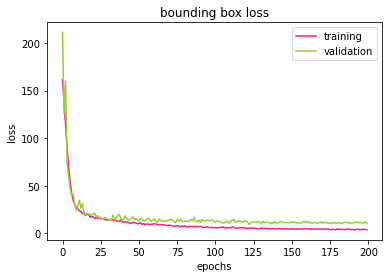

In [18]:
# PLOT BOUNDING BOX TRAINING LOSS AND VALIDATION LOSS

plt.plot(history.history['dense_loss'], color='deeppink')
plt.plot(history.history['val_dense_loss'], color='yellowgreen')
plt.title('bounding box loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

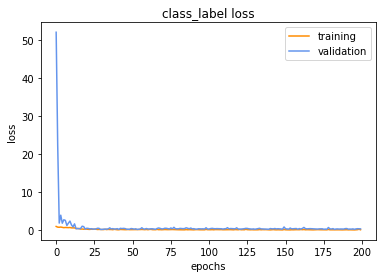

In [21]:
# PLOT CLASS LABEL TRAINING LOSS AND VALIDATION LOSS

plt.plot(history.history['dense_1_loss'], color='darkorange')
plt.plot(history.history['val_dense_1_loss'], color='cornflowerblue')
plt.title('class_label loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [29]:
test_image = './resized_image/2000_3.jpeg'

img = read_image(test_image)
img = np.array([img])
predict = model.predict(img)
predict

[array([[ 57.67923,  39.58072, 227.94456, 399.15668]], dtype=float32),
 array([[1.1508735e-10, 3.3895114e-05, 1.2555165e-04, 6.5648351e-08,
         2.3911090e-07, 1.9481046e-08, 9.9984026e-01]], dtype=float32)]

First array contains the bounding box coordinates
Second array contains probability of class labels

In [48]:
# INFERENCE CODE
currency_dict = {0:'50Rs', 1:'500Rs', 2:'100Rs', 3:'10Rs', 4:'20Rs', 5:'200Rs', 6:'2000Rs'}

def identify_currency(image_path):
    
    x = read_image(image_path)
    img = read_image(test_image)
    img = np.array([img])
    predict = model.predict(img)
    confidence = predict[1][0][np.argmax(predict[1][0])]
    curr = currency_dict[np.argmax(predict[1][0])]
    print(" The detected currency is {} and the model is {} % sure about it".format(curr, round(confidence*100, 2)))
    plot_bb(image_path, predict[0][0])

### TESTING OF THE MODEL

 The detected currency is 2000Rs and the model is 99.98 % sure about it


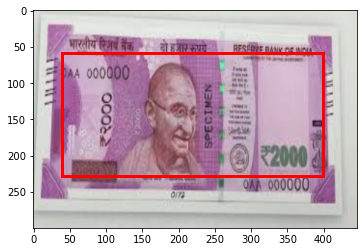

In [49]:
test_image = './resized_image/2000_3.jpeg'

identify_currency(test_image)

 The detected currency is 500Rs and the model is 99.86 % sure about it


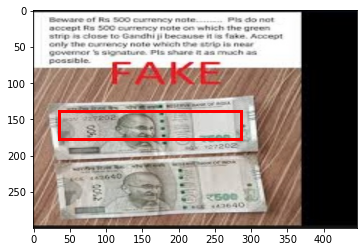

In [50]:
test_image = './resized_image/500_64.jpeg'

identify_currency(test_image)

 The detected currency is 200Rs and the model is 94.53 % sure about it


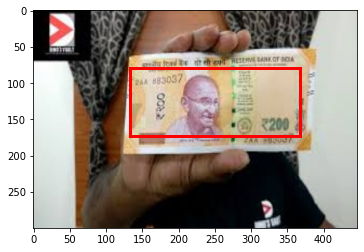

In [51]:
test_image = './resized_image/200_46.jpeg'

identify_currency(test_image)

 The detected currency is 10Rs and the model is 99.86 % sure about it


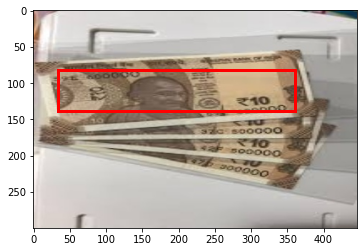

In [52]:
test_image = './resized_image/10_29 (copy).jpeg'

identify_currency(test_image)

 The detected currency is 50Rs and the model is 100.0 % sure about it


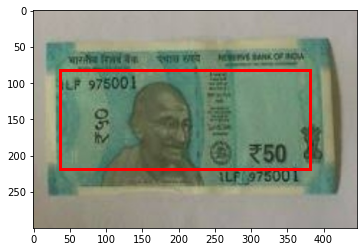

In [53]:
test_image = './resized_image/50_43 (copy).jpeg'

identify_currency(test_image)

 The detected currency is 100Rs and the model is 100.0 % sure about it


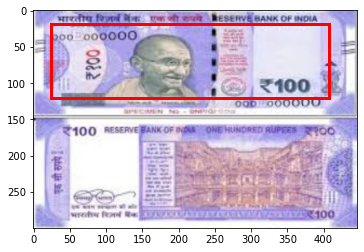

In [54]:
test_image = './resized_image/100_37.jpeg'

identify_currency(test_image)

 The detected currency is 20Rs and the model is 99.97 % sure about it


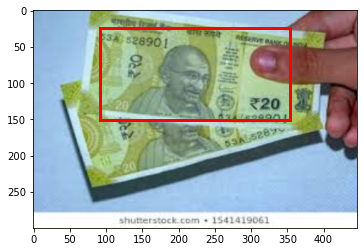

In [55]:
test_image = './resized_image/20_19 (copy).jpeg'

identify_currency(test_image)

For more information, refer to this notebook https://www.kaggle.com/shweta2407/objectdetection-on-custom-dataset-resnet34

#### THANK YOU